In [1]:
import re
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import geopandas as gpd
from shapely.geometry import Point, LineString
import networkx as nx
import gurobipy as gb
from keplergl import KeplerGl
from gtfs_functions import Feed
from sklearn.metrics.pairwise import manhattan_distances

In [2]:
logging.getLogger().setLevel(logging.WARNING)

## Loading data


In [ ]:
NUM_ROUTES = 3
distance_matrix = pd.read_json("distance_matrix.json")

In [ ]:
# add depot to distance matrix
for i in range(NUM_ROUTES):
    distance_matrix.loc[i+1] = 0.0
    distance_matrix[i+1] = 0.0

distance_matrix

In [ ]:
np.nanmax(distance_matrix.to_numpy())

In [ ]:
distance_matrix.fillna(1e2, inplace=True)

In [ ]:
distance_matrix

In [ ]:
nodes = list(distance_matrix.index)
num_nodes = len(nodes)

# TSP - Bus Route Optimization

In [ ]:
vrp = gb.Model("Montreal Bus Routing")
vrp.Params.MIPGap = 0.3
vrp.Params.TimeLimit = 30
start_node_index = 68


# Decision variables
x = vrp.addVars(nodes, nodes, vtype=gb.GRB.BINARY, name="x")

u = vrp.addVars(nodes, vtype=gb.GRB.INTEGER, name="u", ub=num_nodes)

# Objective function
vrp.setObjective(
    gb.quicksum(distance_matrix.loc[i, j] * x[i, j] for i in nodes for j in nodes),
    gb.GRB.MINIMIZE,
)

# Constraints
vrp.addConstrs(
    (gb.quicksum(x[i, j] for j in nodes if j != i) == 1 for i in nodes),
    name="outgoing",
)

vrp.addConstrs(
    (gb.quicksum(x[j, i] for j in nodes if j != i) == 1 for i in nodes),
    name="ingoing",
)

vrp.addConstrs(
    (
        u[i] - u[j] + num_nodes * x[i, j] <= num_nodes - 1
        for i in nodes
        for j in nodes
        if i != j and i != nodes[start_node_index] and j != nodes[start_node_index]
    ),
    name="subtour_elimination",
)

vrp.addConstrs(
    (u[i] >= 2 for i in nodes if i != nodes[start_node_index]), name="lower bound for u"
)

vrp.addConstr(
    u[nodes[start_node_index]] == 1,
    name="start node index is 1",
)

vrp.optimize()

In [ ]:
nodes[start_node_index]

In [ ]:
print("Minimum distance: ", vrp.objVal)
print("Optimal path: ")
tour = []
for v in vrp.getVars():
    if v.varName.startswith("u"):
        tour.append(v)

for s in sorted(tour, key=lambda x: x.x):
    print(s.varName, s.x)

In [ ]:
# Distances
distances = []

for i in nodes:
    for j in nodes:
        if x[i, j].x == 1:
            distances.append(distance_matrix[i][j])

pd.Series(distances).describe()

In [ ]:
# Plotting the directed graph
G = nx.DiGraph()

for i in nodes:
    for j in nodes:
        if x[i, j].x == 1:
            G.add_edge(
                i, j, weight=distance_matrix[i][j], step=u[i].x, label=f"{i}-{j}"
            )

pos = nx.spring_layout(G)
steps = nx.get_edge_attributes(G, "step")

from pyvis.network import Network

net = Network(
    directed=True,
    notebook=True,
    select_menu=True,
    filter_menu=True,
    cdn_resources="remote",
    neighborhood_highlight=True,
)

net.from_nx(G)
net.show_buttons()


net.show("example.html")

In [ ]:
# convert tour into dictionary of steps and nodes

tour_dict = {}

for node in tour:
    node_name = node.varName

    node_name = re.sub(r"[u\[\]]", "", node_name)
    tour_dict[node.x] = int(node_name)

tour_df = (
    pd.DataFrame.from_dict(tour_dict, orient="index", columns=["node"])
    .sort_index()
    .reset_index()
    .rename(columns={"index": "step"})
)

tour_df = tour_df.merge(stops, left_on="node", right_on="stop_code", how="left")

tour_df["stop_lat"] = tour_df["stop_lat"].fillna(45.5376881)
tour_df["stop_lon"] = tour_df["stop_lon"].fillna(-73.5705049)
tour_df["stop_name"] = tour_df["stop_name"].fillna("Depot")

tour_df["geometry"] = tour_df.apply(
    lambda x: Point((float(x.stop_lon), float(x.stop_lat))), axis=1
)

tour_df = gpd.GeoDataFrame(tour_df, geometry="geometry")

tour_df

In [ ]:
depot_steps = tour_df[tour_df["stop_name"] == "Depot"].index.tolist()

tours = []

for i in range(len(depot_steps) - 1):
    tours.append(tour_df.iloc[depot_steps[i] : depot_steps[i + 1] + 1])

tours.append(tour_df.iloc[depot_steps[-1] :])

In [ ]:
tour_lines = []

for i, tour_ in enumerate(tours):
    tour_lines.append({"route_id": i, "geometry": LineString(tour_.geometry.tolist())})


tour_lines = gpd.GeoDataFrame.from_dict(tour_lines, geometry="geometry")

tour_lines

In [ ]:
config = {
    "version": "v1",
    "config": {
        "visState": {
            "filters": [
                {
                    "dataId": ["routes"],
                    "id": "cc52bgyolv",
                    "name": ["route_id"],
                    "type": "range",
                    "value": [0, 0.73],
                    "enlarged": False,
                    "plotType": "histogram",
                    "animationWindow": "free",
                    "yAxis": None,
                    "speed": 1,
                }
            ],
            "layers": [
                {
                    "id": "w9xelah",
                    "type": "point",
                    "config": {
                        "dataId": "stops_in_trip",
                        "label": "stop",
                        "color": [221, 178, 124],
                        "highlightColor": [252, 242, 26, 255],
                        "columns": {
                            "lat": "stop_lat",
                            "lng": "stop_lon",
                            "altitude": "step",
                        },
                        "isVisible": True,
                        "visConfig": {
                            "radius": 10,
                            "fixedRadius": False,
                            "opacity": 0.8,
                            "outline": False,
                            "thickness": 2,
                            "strokeColor": None,
                            "colorRange": {
                                "name": "Global Warming",
                                "type": "sequential",
                                "category": "Uber",
                                "colors": [
                                    "#5A1846",
                                    "#900C3F",
                                    "#C70039",
                                    "#E3611C",
                                    "#F1920E",
                                    "#FFC300",
                                ],
                            },
                            "strokeColorRange": {
                                "name": "Global Warming",
                                "type": "sequential",
                                "category": "Uber",
                                "colors": [
                                    "#5A1846",
                                    "#900C3F",
                                    "#C70039",
                                    "#E3611C",
                                    "#F1920E",
                                    "#FFC300",
                                ],
                            },
                            "radiusRange": [0, 50],
                            "filled": True,
                        },
                        "hidden": False,
                        "textLabel": [
                            {
                                "field": None,
                                "color": [255, 255, 255],
                                "size": 18,
                                "offset": [0, 0],
                                "anchor": "start",
                                "alignment": "center",
                            }
                        ],
                    },
                    "visualChannels": {
                        "colorField": {"name": "step", "type": "integer"},
                        "colorScale": "quantile",
                        "strokeColorField": None,
                        "strokeColorScale": "quantile",
                        "sizeField": None,
                        "sizeScale": "linear",
                    },
                },
                {
                    "id": "ez5bm5",
                    "type": "geojson",
                    "config": {
                        "dataId": "routes",
                        "label": "routes",
                        "color": [30, 150, 190],
                        "highlightColor": [252, 242, 26, 255],
                        "columns": {"geojson": "geometry"},
                        "isVisible": True,
                        "visConfig": {
                            "opacity": 0.8,
                            "strokeOpacity": 0.8,
                            "thickness": 1,
                            "strokeColor": None,
                            "colorRange": {
                                "name": "Global Warming",
                                "type": "sequential",
                                "category": "Uber",
                                "colors": [
                                    "#5A1846",
                                    "#900C3F",
                                    "#C70039",
                                    "#E3611C",
                                    "#F1920E",
                                    "#FFC300",
                                ],
                            },
                            "strokeColorRange": {
                                "name": "ColorBrewer Paired-5",
                                "type": "qualitative",
                                "category": "ColorBrewer",
                                "colors": [
                                    "#a6cee3",
                                    "#1f78b4",
                                    "#b2df8a",
                                    "#33a02c",
                                    "#fb9a99",
                                ],
                            },
                            "radius": 10,
                            "sizeRange": [0, 10],
                            "radiusRange": [0, 50],
                            "heightRange": [0, 500],
                            "elevationScale": 5,
                            "enableElevationZoomFactor": True,
                            "stroked": True,
                            "filled": False,
                            "enable3d": False,
                            "wireframe": False,
                        },
                        "hidden": False,
                        "textLabel": [
                            {
                                "field": None,
                                "color": [255, 255, 255],
                                "size": 18,
                                "offset": [0, 0],
                                "anchor": "start",
                                "alignment": "center",
                            }
                        ],
                    },
                    "visualChannels": {
                        "colorField": None,
                        "colorScale": "quantile",
                        "strokeColorField": {"name": "route_id", "type": "integer"},
                        "strokeColorScale": "quantile",
                        "sizeField": None,
                        "sizeScale": "linear",
                        "heightField": None,
                        "heightScale": "linear",
                        "radiusField": None,
                        "radiusScale": "linear",
                    },
                },
            ],
            "interactionConfig": {
                "tooltip": {
                    "fieldsToShow": {
                        "stops_in_trip": [
                            {"name": "stop_name", "format": None},
                            {"name": "step", "format": None},
                        ],
                        "routes": [{"name": "route_id", "format": None}],
                    },
                    "compareMode": False,
                    "compareType": "absolute",
                    "enabled": True,
                },
                "brush": {"size": 0.5, "enabled": False},
                "geocoder": {"enabled": False},
                "coordinate": {"enabled": False},
            },
            "layerBlending": "normal",
            "splitMaps": [],
            "animationConfig": {"currentTime": None, "speed": 1},
        },
        "mapState": {
            "bearing": 0,
            "dragRotate": False,
            "latitude": 45.59783403161273,
            "longitude": -73.62435981591366,
            "pitch": 0,
            "zoom": 10,
            "isSplit": False,
        },
        "mapStyle": {
            "styleType": "light",
            "topLayerGroups": {},
            "visibleLayerGroups": {
                "label": True,
                "road": True,
                "border": False,
                "building": True,
                "water": True,
                "land": True,
                "3d building": False,
            },
            "threeDBuildingColor": [
                218.82023004728686,
                223.47597962276103,
                223.47597962276103,
            ],
            "mapStyles": {},
        },
    },
}

In [ ]:
map = KeplerGl(height=700, config=config)

map.add_data(
    data=tour_df[["stop_lat", "stop_lon", "stop_name", "step"]],
    name="stops_in_trip",
)

map.add_data(
    data=tour_lines[['route_id', 'geometry']],
    name="routes",
)

map

# VRP - Number of buses

In [ ]:
# feed = Feed("./STM GTFS/gtfs_stm.zip", busiest_date=False)

In [ ]:
# routes = feed.routes
# trips = feed.trips
# stops = feed.stops
# stop_times = feed.stop_times
# shapes = feed.shapes
# segments = feed.segments

In [3]:
segments = pd.read_csv("segments.csv")
stops = pd.read_csv("stops.csv")

segments[['route_id', 'start_stop_id', 'end_stop_id']] = segments[['route_id', 'start_stop_id', 'end_stop_id']].astype(str)

In [4]:
def get_segment_stops(segment_df, route_id, direction_id=0):
    segment_distance = segment_df.query(
        "route_id == @route_id & direction_id == @direction_id"
    )

    stops_in_route = stops[
        stops["stop_id"].isin(
            list(
                set(
                    segment_distance[["start_stop_id", "end_stop_id"]].values.reshape(
                        -1
                    )
                )
            )
        )
    ]

    return segment_distance, stops_in_route

### Get stops on route

In [5]:
routes = ["35", "61", "15", "51", "18", "107", "144"]
route_details = {}

for r in routes:
    detail = get_segment_stops(segments, r, 0)

    route_details[r] = {}
    route_details[r]["segment"] = detail[0]
    route_details[r]["stops"] = detail[1]

In [6]:
stops_df = pd.concat([v["stops"] for k, v in route_details.items()]).drop_duplicates()
print(f"Number of total stops in routes: {len(stops_df)}")
stops_df.head()

Number of total stops in routes: 229


,stop_id,stop_code,stop_name,stop_lat,stop_lon,stop_url,location_type,parent_station,wheelchair_boarding,geometry
422,61743,61743,Notre-Dame / Guy,45.489959,-73.567233,https://www.stm.info/fr/recherche#stq=61743,0,NaN,1,POINT (-73.567233 45.489959)
423,61744,61744,de la Montagne / Ottawa,45.492014,-73.561145,https://www.stm.info/fr/recherche#stq=61744,0,NaN,1,POINT (-73.561145 45.492014)
424,61745,61745,de la Montagne / du Square-Gallery,45.491756,-73.558727,https://www.stm.info/fr/recherche#stq=61745,0,NaN,1,POINT (-73.558727 45.491756)
438,61765,61765,Wellington / Prince,45.496656,-73.555554,https://www.stm.info/fr/recherche#stq=61765,0,NaN,1,POINT (-73.555554 45.496656)
591,62063,62063,Notre-Dame / Bérard,45.480191,-73.579727,https://www.stm.info/fr/recherche#stq=62063,0,NaN,1,POINT (-73.579727 45.480191)


## Visualize stops on a map

In [7]:
stops_df["geometry"] = stops_df.apply(
    lambda x: Point((float(x.stop_lon), float(x.stop_lat))), axis=1
)

stops_df_gpd = gpd.GeoDataFrame(stops_df, geometry="geometry").drop(
    columns=["location_type", "parent_station", "wheelchair_boarding"]
)

stops_df_gpd.head()

,stop_id,stop_code,stop_name,stop_lat,stop_lon,stop_url,geometry
422,61743,61743,Notre-Dame / Guy,45.489959,-73.567233,https://www.stm.info/fr/recherche#stq=61743,POINT (-73.56723 45.48996)
423,61744,61744,de la Montagne / Ottawa,45.492014,-73.561145,https://www.stm.info/fr/recherche#stq=61744,POINT (-73.56114 45.49201)
424,61745,61745,de la Montagne / du Square-Gallery,45.491756,-73.558727,https://www.stm.info/fr/recherche#stq=61745,POINT (-73.55873 45.49176)
438,61765,61765,Wellington / Prince,45.496656,-73.555554,https://www.stm.info/fr/recherche#stq=61765,POINT (-73.55555 45.49666)
591,62063,62063,Notre-Dame / Bérard,45.480191,-73.579727,https://www.stm.info/fr/recherche#stq=62063,POINT (-73.57973 45.48019)


In [9]:
random_stops_df_gpd = stops_df_gpd.sample(frac=0.1, random_state=420)

random_stops_df_gpd.head()

,stop_id,stop_code,stop_name,stop_lat,stop_lon,stop_url,geometry
7000,56597,56597,de Verdun / Regina,45.467209,-73.570880,https://www.stm.info/fr/recherche#stq=56597,POINT (-73.57088 45.46721)
655,62137,62137,Saint-Denis / des Pins,45.518614,-73.571409,https://www.stm.info/fr/recherche#stq=62137,POINT (-73.57141 45.51861)
4417,54207,54207,Louis-Hippolyte-La Fontaine / Pierre-Corneille,45.595176,-73.545178,https://www.stm.info/fr/recherche#stq=54207,POINT (-73.54518 45.59518)
3071,58803,58803,Notre-Dame / de la Montagne,45.492703,-73.564865,https://www.stm.info/fr/recherche#stq=58803,POINT (-73.56486 45.49270)
2061,51551,51551,Beaubien / Saint-Hubert,45.535993,-73.603111,https://www.stm.info/fr/recherche#stq=51551,POINT (-73.60311 45.53599)


In [11]:
# Add a depot stop to the random stops dataframe in the beginning
depot = pd.DataFrame(
    {
        "stop_id": ["0"],
        "stop_name": ["Depot"],
        "stop_lat": [45.5048542],
        "stop_lon": [-73.5691235],
        "stop_code": 0.0,
    }
)

depot["geometry"] = Point((float(depot.stop_lon), float(depot.stop_lat)))

random_stops_df_gpd = pd.concat([depot, random_stops_df_gpd]).reset_index(drop=True)

random_stops_df_gpd

,stop_id,stop_name,stop_lat,stop_lon,stop_code,geometry,stop_url
0,0,Depot,45.504854,-73.569124,0.0,POINT (-73.5691235 45.5048542),NaN
1,56597,de Verdun / Regina,45.467209,-73.570880,56597.0,POINT (-73.57088 45.467209),https://www.stm.info/fr/recherche#stq=56597
2,62137,Saint-Denis / des Pins,45.518614,-73.571409,62137.0,POINT (-73.571409 45.518614),https://www.stm.info/fr/recherche#stq=62137
3,54207,Louis-Hippolyte-La Fontaine / Pierre-Corneille,45.595176,-73.545178,54207.0,POINT (-73.545178 45.595176),https://www.stm.info/fr/recherche#stq=54207
4,58803,Notre-Dame / de la Montagne,45.492703,-73.564865,58803.0,POINT (-73.564865 45.492703),https://www.stm.info/fr/recherche#stq=58803
5,51551,Beaubien / Saint-Hubert,45.535993,-73.603111,51551.0,POINT (-73.603111 45.535993),https://www.stm.info/fr/recherche#stq=51551
6,54398,Saint-Laurent / Saint-Zotique,45.531520,-73.611216,54398.0,POINT (-73.611216 45.53152),https://www.stm.info/fr/recherche#stq=54398
7,52840,Beaubien / Pierre-Gadois,45.592686,-73.557766,52840.0,POINT (-73.557766 45.592686),https://www.stm.info/fr/recherche#stq=52840
8,51214,Édouard-Montpetit / McKenna,45.501108,-73.620699,51214.0,POINT (-73.620699 45.501108),https://www.stm.info/fr/recherche#stq=51214
9,53842,du Docteur-Penfield / Côte-des-Neiges,45.496707,-73.586311,53842.0,POINT (-73.586311 45.496707),https://www.stm.info/fr/recherche#stq=53842


### Calculate Manhattan distance between stops

In [12]:
distance_matrix = pd.DataFrame(
    manhattan_distances(random_stops_df_gpd[["stop_lat", "stop_lon"]].values),
    index=random_stops_df_gpd["stop_id"],
    columns=random_stops_df_gpd["stop_id"],
)

display(distance_matrix.head())

stop_id,0,56597,62137,54207,58803,51551,54398,52840,51214,53842,...,53898,56580,52705,50799,52325,52053,53751,56636,52826,52916
stop_id,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.039402,0.016045,0.114267,0.016410,0.065126,0.068758,0.099189,0.055322,0.025335,...,0.031088,0.055550,0.008921,0.101219,0.013027,0.041651,0.083437,0.044370,0.012517,0.024491
56597,0.039402,0.000000,0.051934,0.153669,0.031509,0.101015,0.104647,0.138591,0.083718,0.044929,...,0.031325,0.016148,0.041564,0.074709,0.034733,0.023743,0.122839,0.008481,0.044764,0.063893
62137,0.016045,0.051934,0.000000,0.102793,0.032455,0.049081,0.052713,0.087715,0.066796,0.036809,...,0.047133,0.067024,0.024966,0.112693,0.024501,0.053125,0.071963,0.060415,0.028562,0.015571
54207,0.114267,0.153669,0.102793,0.000000,0.122160,0.117116,0.129694,0.015078,0.169589,0.139602,...,0.122344,0.169817,0.112105,0.215486,0.127294,0.155918,0.030830,0.154290,0.108905,0.089776
58803,0.016410,0.031509,0.032455,0.122160,0.000000,0.081536,0.085168,0.107082,0.064239,0.025450,...,0.014678,0.047657,0.010055,0.093326,0.015254,0.033758,0.091330,0.032130,0.013255,0.032384


In [13]:
config = {
    "version": "v1",
    "config": {
        "visState": {
            "filters": [],
            "layers": [
                {
                    "id": "pha44gc",
                    "type": "point",
                    "config": {
                        "dataId": "stops",
                        "label": "stop",
                        "color": [30, 150, 190],
                        "highlightColor": [252, 242, 26, 255],
                        "columns": {
                            "lat": "stop_lat",
                            "lng": "stop_lon",
                            "altitude": None,
                        },
                        "isVisible": True,
                        "visConfig": {
                            "radius": 15,
                            "fixedRadius": False,
                            "opacity": 1,
                            "outline": False,
                            "thickness": 2,
                            "strokeColor": [28, 27, 27],
                            "colorRange": {
                                "name": "Uber Viz Qualitative 3",
                                "type": "qualitative",
                                "category": "Uber",
                                "colors": [
                                    "#12939A",
                                    "#DDB27C",
                                    "#88572C",
                                    "#FF991F",
                                    "#F15C17",
                                    "#223F9A",
                                    "#DA70BF",
                                    "#125C77",
                                    "#4DC19C",
                                    "#776E57",
                                    "#17B8BE",
                                    "#F6D18A",
                                    "#B7885E",
                                    "#FFCB99",
                                    "#F89570",
                                ],
                            },
                            "strokeColorRange": {
                                "name": "Global Warming",
                                "type": "sequential",
                                "category": "Uber",
                                "colors": [
                                    "#5A1846",
                                    "#900C3F",
                                    "#C70039",
                                    "#E3611C",
                                    "#F1920E",
                                    "#FFC300",
                                ],
                            },
                            "radiusRange": [0, 50],
                            "filled": True,
                        },
                        "hidden": False,
                        "textLabel": [
                            {
                                "field": None,
                                "color": [255, 255, 255],
                                "size": 18,
                                "offset": [0, 0],
                                "anchor": "start",
                                "alignment": "center",
                            }
                        ],
                    },
                    "visualChannels": {
                        "colorField": {"name": "stop_name", "type": "string"},
                        "colorScale": "ordinal",
                        "strokeColorField": None,
                        "strokeColorScale": "quantile",
                        "sizeField": None,
                        "sizeScale": "linear",
                    },
                }
            ],
            "interactionConfig": {
                "tooltip": {
                    "fieldsToShow": {
                        "stops": [
                            {"name": "stop_name", "format": None},
                            {"name": "stop_id", "format": None},
                        ]
                    },
                    "compareMode": False,
                    "compareType": "absolute",
                    "enabled": True,
                },
                "brush": {"size": 0.5, "enabled": False},
                "geocoder": {"enabled": False},
                "coordinate": {"enabled": True},
            },
            "layerBlending": "normal",
            "splitMaps": [],
            "animationConfig": {"currentTime": None, "speed": 1},
        },
        "mapState": {
            "bearing": 0,
            "dragRotate": False,
            "latitude": 45.49373589563174,
            "longitude": -73.57232342042659,
            "pitch": 0,
            "zoom": 11.401161292661241,
            "isSplit": False,
        },
        "mapStyle": {
            "styleType": "light",
            "topLayerGroups": {},
            "visibleLayerGroups": {
                "label": True,
                "road": True,
                "border": False,
                "building": True,
                "water": True,
                "land": True,
                "3d building": False,
            },
            "threeDBuildingColor": [
                218.82023004728686,
                223.47597962276103,
                223.47597962276103,
            ],
            "mapStyles": {},
        },
    },
}

In [14]:
stop_map = KeplerGl(height=700, config=config)

stop_map.add_data(
    data=random_stops_df_gpd[["stop_lat", "stop_lon", "stop_name", "stop_id"]],
    name="stops",
)

stop_map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'pha44gc', 'type': …

## Using Gurobi to solve the VRP - no capacity constraints

In [62]:
# --------------------------------------------------------------------------------
# Paramters
distance_matrix_model = distance_matrix

stops = list(distance_matrix_model.index)
num_stops = len(stops)

num_buses = 5

model = gb.Model("Bus Routing")
model.Params.MIPGap = 0.1
model.Params.TimeLimit = 300

# display(distance_matrix_model)

# --------------------------------------------------------------------------------
# Decision variables
x = model.addVars(
    stops,
    stops,
    num_buses,
    vtype=gb.GRB.BINARY,
    name=(
        f"{i} -> {j} (Bus {k+1})"
        for i in stops
        for j in stops
        for k in range(num_buses)
    ),
)

u = model.addVars(
    stops,
    num_buses,
    vtype=gb.GRB.INTEGER,
    lb=0,
    ub=num_stops,
    name=(f"Step for stop {i} (Bus {k+1})" for i in stops for k in range(num_buses)),
)

# --------------------------------------------------------------------------------
# Objective function
model.setObjective(
    gb.quicksum(
        distance_matrix_model.loc[i, j] * x[i, j, k]
        for i in stops
        for j in stops
        for k in range(num_buses)
    ),
    gb.GRB.MINIMIZE,
)

# --------------------------------------------------------------------------------
# Constraints

# Each stop is visited once by one vehicle only
model.addConstrs(
    (
        gb.quicksum(x[i, j, k] for j in stops if j != i for k in range(num_buses)) == 1
        for i in stops[1:]
    ),
    name="outgoing",
)

model.addConstrs(
    (
        gb.quicksum(x[i, j, k] for i in stops if i != j for k in range(num_buses)) == 1
        for j in stops[1:]
    ),
    name="incoming",
)

# Each vehicle leaves the depot and returns to the depot
model.addConstrs(
    (
        gb.quicksum(x[stops[0], j, k] for j in stops if j != stops[0]) == 1
        for k in range(num_buses)
    ),
    name="Vehicle leaves depot",
)

model.addConstrs(
    (
        gb.quicksum(x[i, stops[0], k] for i in stops if i != stops[0]) == 1
        for k in range(num_buses)
    ),
    name="Vehicle returns to depot",
)

# Flow conservation (routes are continuous)
model.addConstrs(
    (
        gb.quicksum(x[j, i, k] for j in stops if j != i)
        - gb.quicksum(x[i, j, k] for j in stops if j != i)
        == 0
        for i in stops[1:]
        for k in range(num_buses)
    ),
    name="Flow conservation",
)

# Subtour elimination
model.addConstrs(
    (
        u[i, k] - u[j, k] + num_stops * x[i, j, k] <= num_stops - 1
        for i in stops
        for j in stops
        for k in range(num_buses)
        if i != j and i != stops[0] and j != stops[0]
    ),
    name="Subtour elimination",
)

model.addConstrs(
    (u[stops[0], k] == 0 for k in range(num_buses)), name="Start node index is 0 (depot) for all buses"
)

Set parameter MIPGap to value 0.1
Set parameter TimeLimit to value 300


{0: <gurobi.Constr *Awaiting Model Update*>,
 1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>}

In [63]:
# Optimize
model.update()
model.optimize()

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 38911 rows, 40050 columns and 270605 nonzeros
Model fingerprint: 0xb575d538
Variable types: 0 continuous, 40050 integer (39605 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+01]
  Objective range  [1e-03, 2e-01]
  Bounds range     [1e+00, 9e+01]
  RHS range        [1e+00, 9e+01]
Presolve removed 5 rows and 450 columns
Presolve time: 0.52s
Presolved: 38906 rows, 39600 columns, 270600 nonzeros
Variable types: 0 continuous, 39600 integer (39160 binary)
Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Use crossover to convert LP symmetric solution to basic solution...

Root relaxation: objective 6.093062e-01, 668 iterations, 0.23 seconds (0.

## Using Gurobi to solve the VRP - capacity constraints

In [15]:
# --------------------------------------------------------------------------------
# Paramters
g = np.random.default_rng(420)

distance_matrix_model = distance_matrix

stops = list(distance_matrix_model.index)
num_stops = len(stops)

demand_stops = {stop: g.integers(1, 10) for stop in stops}
demand_stops[stops[0]] = 0  # Depot has no demand

num_buses = 3
BUS_CAPACITY = 75

model = gb.Model("Bus Routing")
model.Params.MIPGap = 0.1
model.Params.TimeLimit = 300

# display(distance_matrix_model)

# --------------------------------------------------------------------------------
# Decision variables
x = model.addVars(
    stops,
    stops,
    num_buses,
    vtype=gb.GRB.BINARY,
    name=(
        f"{i} -> {j} (Bus {k+1})"
        for i in stops
        for j in stops
        for k in range(num_buses)
    ),
)

u = model.addVars(
    stops,
    vtype=gb.GRB.INTEGER,
    lb=0,
    ub=BUS_CAPACITY,
    name=(f"Step for stop {i}" for i in stops),
)

# --------------------------------------------------------------------------------
# Objective function
model.setObjective(
    gb.quicksum(
        distance_matrix_model.loc[i, j] * x[i, j, k]
        for i in stops
        for j in stops
        for k in range(num_buses)
    ),
    gb.GRB.MINIMIZE,
)

# --------------------------------------------------------------------------------
# Constraints

# Vehicle leaves nodes that it enters
model.addConstrs(
    (
        gb.quicksum(x[j, i, k] for j in stops if j != i)
        - gb.quicksum(x[i, j, k] for j in stops if j != i)
        == 0
        for i in stops[1:]
        for k in range(num_buses)
    ),
    name="Vehicle leaves nodes that it enters",
)

# Every node is entered once
model.addConstrs(
    (
        gb.quicksum(x[i, j, k] for j in stops if j != i for k in range(num_buses)) == 1
        for i in stops[1:]
    ),
    name="Every node is entered once",
)

# Every vehicle leaves the depot
model.addConstrs(
    (gb.quicksum(x[stops[0], j, k] for j in stops[1:]) == 1 for k in range(num_buses)),
    name="Every vehicle leaves the depot",
)

# Capacity constraint
model.addConstrs(
    (
        gb.quicksum(demand_stops[j] * x[i, j, k] for j in stops[1:]) <= BUS_CAPACITY
        for i in stops
        for k in range(num_buses)
    ),
    name="Capacity constraint",
)

# Subtour elimination constraint
model.addConstrs(
    (
        u[j] - u[i] >= demand_stops[j] - BUS_CAPACITY * (1 - x[i, j, k])
        for i in stops
        for j in stops
        for k in range(num_buses)
        if i != j and i != stops[0] and j != stops[0]
    ),
    name="Subtour elimination constraint",
)

model.addConstrs(
    (u[i] >= demand_stops[i] for i in stops[1:]),
    name="Lower bound for u",
)

model.addConstr(
    u[stops[0]] == 0,
    name="Start node index is 0 (depot)",
)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-30
Set parameter MIPGap to value 0.1


Set parameter TimeLimit to value 300


<gurobi.Constr *Awaiting Model Update*>

In [16]:
# Optimize
model.update()
model.optimize()

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 1709 rows, 1752 columns and 11064 nonzeros
Model fingerprint: 0x80bcaf30
Variable types: 0 continuous, 1752 integer (1728 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [2e-03, 2e-01]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e+00, 8e+01]
Presolve removed 96 rows and 73 columns
Presolve time: 0.03s
Presolved: 1613 rows, 1679 columns, 9384 nonzeros
Variable types: 0 continuous, 1679 integer (1656 binary)

Root relaxation: objective 4.059882e-01, 146 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.40599    0   43          -    0.40599  

In [17]:
print(f"Optimal objective: {model.objVal}")

# Bus path
bus_path = {}

for k in range(num_buses):
    bus_path[k] = []
    for i in stops:
        for j in stops:
            if x[i, j, k].x == 1:
                bus_path[k].append(
                    {
                        "start_stop": i,
                        "end_stop": j,
                        "distance": distance_matrix_model.loc[i, j],
                        "stop_demand": demand_stops[j],
                        "cumulative_demand": u[j].x,
                    }
                )

# convert to df with bus route number
bus_path_df = []

for k, v in bus_path.items():
    bus_path_df.append(pd.DataFrame(v).assign(bus=k))

bus_path_df = pd.concat(bus_path_df)

bus_path_df

Optimal objective: 0.6434049999999871


,start_stop,end_stop,distance,stop_demand,cumulative_demand,bus
0,0,52705,0.008921,2,39.0,0
1,58803,61743,0.005112,6,75.0,0
2,59223,58803,0.002090,8,69.0,0
3,61743,0,0.016786,0,0.0,0
4,62165,59223,0.010687,6,61.0,0
5,53898,62165,0.006391,1,55.0,0
6,52705,52826,0.003596,9,48.0,0
7,52826,53898,0.018571,6,54.0,0
0,0,52325,0.013027,3,3.0,1
1,56597,56636,0.008481,4,21.0,1


Bus 0:


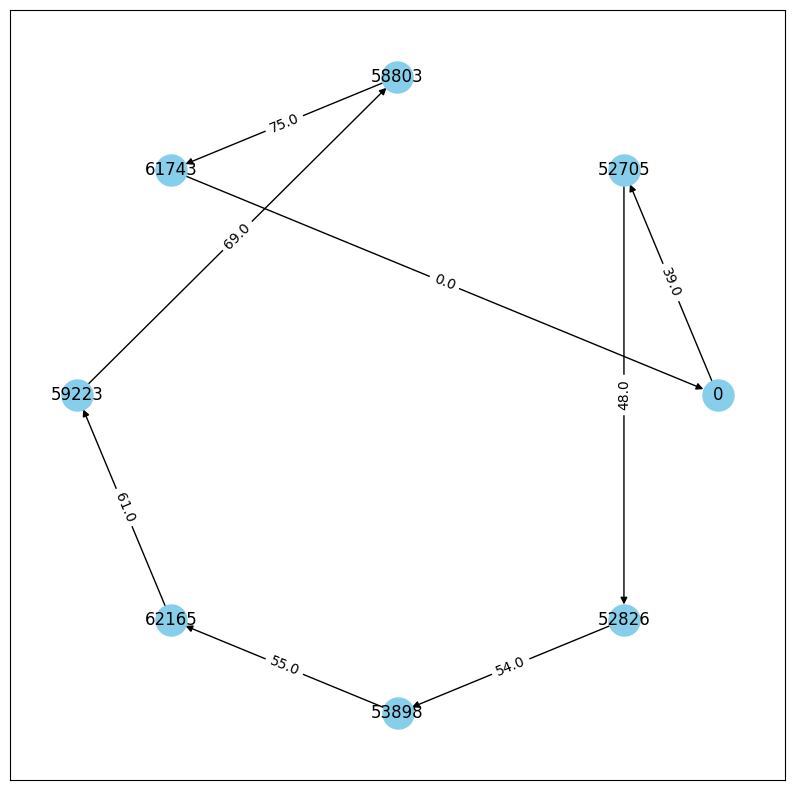



Bus 1:


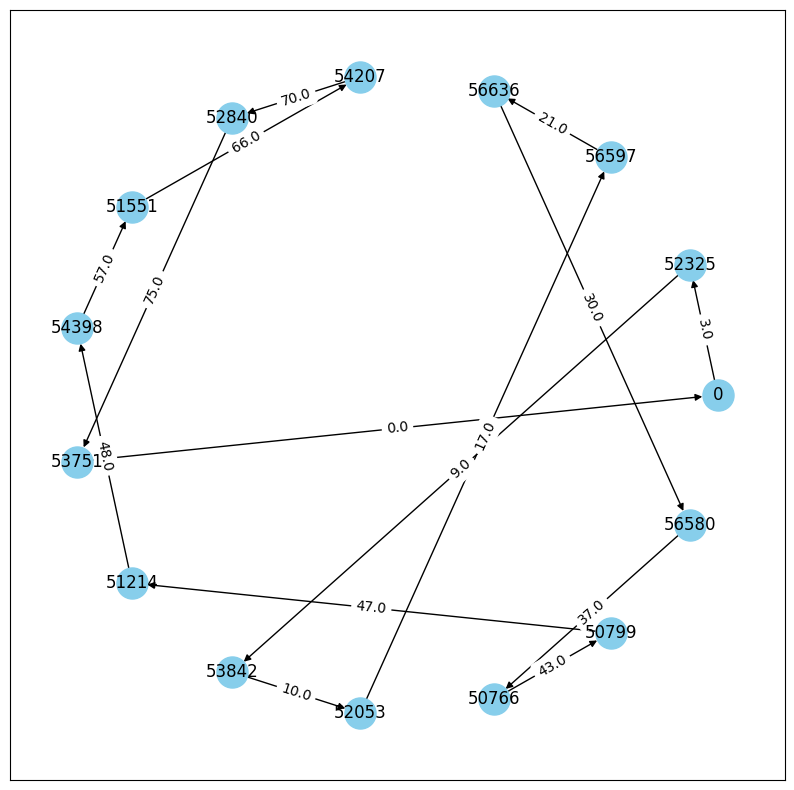



Bus 2:


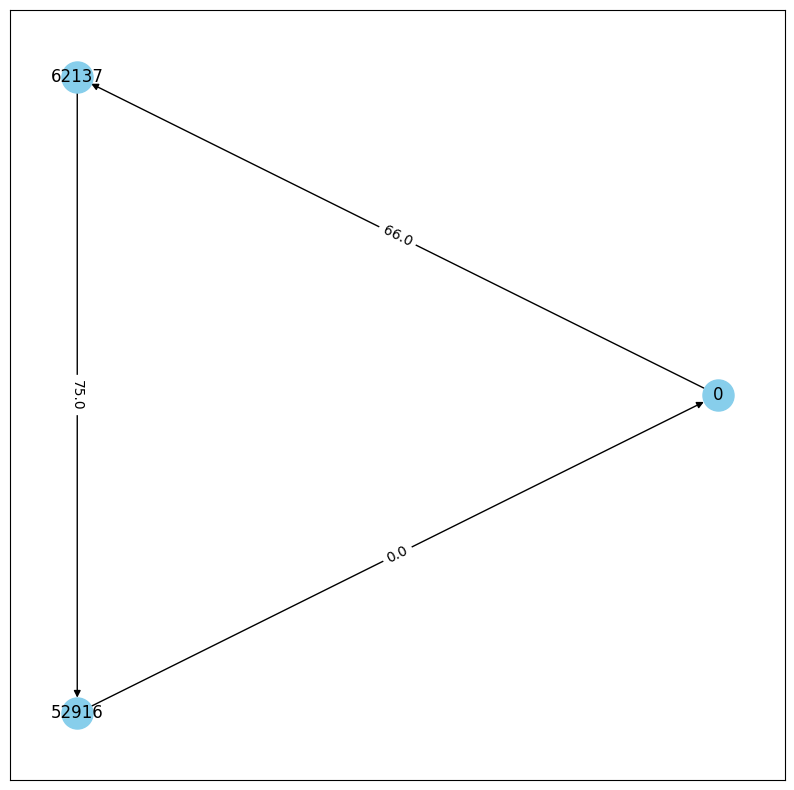

In [18]:
for bus in bus_path_df.bus.unique():
    print(f"Bus {bus}:")

    bus_route = bus_path_df[bus_path_df["bus"] == bus].reset_index(drop=True)

    plt.figure(figsize=(10, 10))

    g = nx.DiGraph()

    for segment in bus_route.itertuples():
        g.add_edge(
            segment.start_stop,
            segment.end_stop,
            weight=segment.distance,
            demand=segment.stop_demand,
            load=segment.cumulative_demand,
        )

    pos = nx.circular_layout(g)

    nx.draw_networkx(g, pos, with_labels=True, node_size=500, node_color="skyblue")
    nx.draw_networkx_edge_labels(g, pos, edge_labels=nx.get_edge_attributes(g, "load"))

    plt.show()

    print("\n")

## Visualize routes to be taken by buses

In [32]:
def print_optimal_paths(model, num_buses, stops):
    routes = {}

    print("Minimum distance: ", model.objVal)
    print("Optimal path for each bus: ")

    for k in range(num_buses):
        print(f"Bus {k+1}:")

        # Initialize with the depot as the starting point
        current_stop = stops[0]
        next_stop = None
        route = [current_stop]  # Start with the depot

        # Follow the path for the current bus
        while next_stop != stops[0]:
            for j in stops:
                if j != current_stop and x[current_stop, j, k].x > 0.5:
                    next_stop = j
                    route.append(next_stop)
                    current_stop = next_stop
                    break
            else:
                # If no next stop is found and we are not at the depot, it indicates an issue
                if current_stop != stops[0]:
                    print(
                        "Error: No valid next stop found. Check the model constraints."
                    )
                break

        routes[k] = route
        print(" -> ".join(map(str, route)))

    return routes

In [33]:
optimal_routes = print_optimal_paths(model, num_buses, stops)

Minimum distance:  0.5413743999998673
Optimal path for each bus: 
Bus 1:
0 -> 62137 -> 0
Bus 2:
0 -> 52325 -> 0
Bus 3:
0 -> 52439 -> 0
Bus 4:
0 -> 52826 -> 0
Bus 5:
0 -> 52336 -> 52705 -> 0


In [34]:
# For each optimal route, generate a GeoDataFrame with the stops and the route


def get_optimal_route_gdf(optimal_routes, stops_df_gpd):
    routes_gdf = {}

    for k, route in optimal_routes.items():
        # Add stops as GeoDataFrame with steps as index of route
        for step, stop in enumerate(route):
            stop_gdf = stops_df_gpd[stops_df_gpd["stop_id"] == stop]
            stop_gdf["step"] = step
            routes_gdf[k] = routes_gdf.get(k, pd.DataFrame()).append(stop_gdf)

    return routes_gdf


routes_gdf = get_optimal_route_gdf(optimal_routes, random_stops_df_gpd)

# add linestring of each point to the next point in the route


def get_route_lines(routes_gdf):
    route_lines = {}

    for k, route in routes_gdf.items():
        route_lines[k] = {
            "route_id": k,
            "geometry": LineString(route.geometry.tolist()),
        }

    return route_lines


route_lines = gpd.GeoDataFrame(
    pd.DataFrame(get_route_lines(routes_gdf)).T.reset_index(drop=True),
    geometry="geometry",
)

In [35]:
route_map = KeplerGl(height=900, config=config)

route_map.add_data(
    data=route_lines[["route_id", "geometry"]],
    name="routes",
)

for k, route in routes_gdf.items():
    route_map.add_data(
        data=route[["stop_lat", "stop_lon", "stop_id", "stop_name", "step"]],
        name=f"stops_in_trip_{k}",
    )

route_map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'pha44gc', 'type': …